In [2]:
import json
import pandas as pd
with open("user-wallet-transactions.json", "r") as file:
    data = json.load(file)
df = pd.DataFrame(data)
print(df.head())


                                    _id  \
0  {'$oid': '681d38fed63812d4655f571a'}   
1  {'$oid': '681aa70dd6df53021cc6f3c0'}   
2  {'$oid': '681d04c2d63812d4654c733e'}   
3  {'$oid': '681d133bd63812d46551b6ef'}   
4  {'$oid': '681899e4ba49fc91cf2f4454'}   

                                   userWallet  network protocol  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6  polygon  aave_v2   
1  0x000000000051d07a4fb3bd10121a343d85818da6  polygon  aave_v2   
2  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
3  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
4  0x0000000000e189dd664b9ab08a33c4839953852c  polygon  aave_v2   

                                              txHash  \
0  0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...   
1  0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...   
2  0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...   
3  0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...   
4  0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...   

 

In [5]:
grouped = df.groupby("userWallet")
features = []
for wallet, group in grouped:
    deposit_count = (group['action'] == 'deposit').sum()
    borrow_count = (group['action'] == 'borrow').sum()
    repay_count = (group['action'] == 'repay').sum()
    liquidation_count = (group['action'] == 'liquidationcall').sum()
    redeem_count = (group['action'] == 'redeemunderlying').sum()

    repay_ratio = repay_count / borrow_count if borrow_count > 0 else 0
    risk_factor = liquidation_count / len(group)

    features.append({
        "wallet": wallet,
        "deposit_count": deposit_count,
        "borrow_count": borrow_count,
        "repay_count": repay_count,
        "repay_ratio": repay_ratio,
        "liquidation_count": liquidation_count,
        "redeem_count": redeem_count,
        "risk_factor": risk_factor
    })

features_df = pd.DataFrame(features)


In [4]:
print(df.columns)

Index(['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId',
       'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt',
       'updatedAt'],
      dtype='object')


**Train a Model**

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
X = features_df.drop(["wallet"], axis=1)
# Use a dummy target if needed
dummy_target = (features_df["repay_ratio"] * 1000) - (features_df["risk_factor"] * 500)
model = RandomForestRegressor()
model.fit(X, dummy_target)
# Generate raw scores
raw_scores = model.predict(X)
scaler = MinMaxScaler(feature_range=(0, 1000))
scaled_scores = scaler.fit_transform(raw_scores.reshape(-1, 1)).flatten()
features_df["score"] = scaled_scores


In [9]:
output = features_df[["wallet", "score"]]
output_records = output.to_dict(orient="records")
import json
with open("wallet_scores.json", "w") as f:
    json.dump(output_records, f, indent=2)


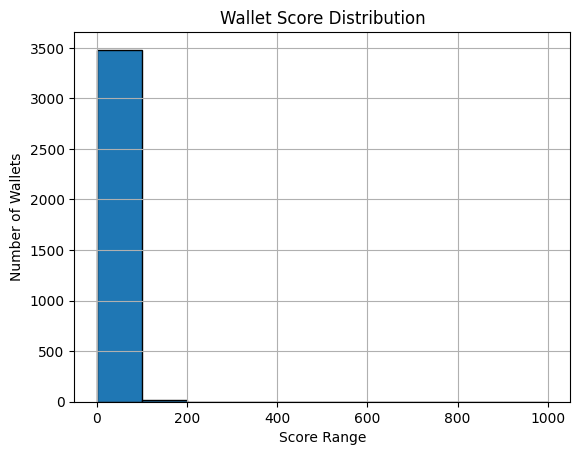

In [10]:
import matplotlib.pyplot as plt

plt.hist(features_df["score"], bins=[0,100,200,300,400,500,600,700,800,900,1000], edgecolor='black')
plt.title("Wallet Score Distribution")
plt.xlabel("Score Range")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.show()
